In [1]:
import xgboost as xgb
import torch
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '../lib')
from treeIO import varData, varDataTraining, ROOTDataset, getFile, rangeData
import numpy as np
import uproot
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics as mt
# from torch.utils.data import DataLoader
from typing import Dict
import matplotlib.pyplot as plt


In [2]:

# custom_callback = CustomCallback()
custom_callback = xgb.callback.TrainingCallback()
# Define your model architecture
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.20,
    reg_lambda=3.,
    reg_alpha=2,
    min_split_loss = 0.02,
    sampling_method = 'uniform',
    objective = 'binary:logistic',
    booster = 'gbtree',
    num_parallel_tree = 10,
    callbacks=[custom_callback],
)
fit = False
# fit = True
# saveTree = True
saveTree = False
doNotLoad = True
doNotLoad = False

# Define your loss function and optimizer
# (Note: XGBoost does not use these, but some packages like PyTorch require them)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
nFileDATA = getFile('Data','Jpsi')[0]
nFileMCPR = getFile('MC','Prompt')[0]
nFileMCNR = getFile('MC','NonPrompt')[0]

batch_size = "50 MB"
DataLoader = ROOTDataset(nFileDATA, "mvaTupler/muonTuple", varDataTraining, '50 MB')
MCLoaderPR = ROOTDataset(nFileMCPR, "mvaTupler/muonTuple", varDataTraining, '100 MB')
MCLoaderNP = ROOTDataset(nFileMCPR, "mvaTupler/muonTuple", varDataTraining, '100 MB')

variables_dict = {var: 'float64' for var in varDataTraining}
vardim = len(varDataTraining)
print(vardim)
num_epochs = 1
var_start_from = 10;
simTypeSignal = [-6,-7,-8,-9-10,6,7,8,9,10]

# train_dataset_signal1 = ROOTDataset(file_path_signal1, tree_name, variables, batch_size)
# train_dataset_background1 = ROOTDataset(file_path_background1, tree_name, variables, batch_size)#, cut = "((mass > 3.8) | (mass < 2.8))")

# Train the model

# Preparing data for training and testing
# Baskets for data aux will include non training variables and raw will be a copy of the full data
inputs = []
# Labels will be 0 for signal and 1 for background
labels = []
inputsAux = []
for idx, inputchunk in enumerate(MCLoaderPR):
    # Convert inputs and labels to NumPy arrays
    keyList = list(inputchunk[1].keys())
    dataValues = np.array(list(inputchunk[1].values())).T
    if idx == 0:
        print(keyList)
    dataValues= dataValues[np.isin(dataValues[:,keyList.index('matching')], simTypeSignal)].squeeze()
    labelchunk = np.full((dataValues.shape[0],1), 1)
    # Append data chun to inputs, index 0 is excluded (dimuon mass variable)
    inputs.append(dataValues[:,var_start_from:])
    inputsAux.append(dataValues[:,:var_start_from-1])
    # Append labels
    labels.append(labelchunk)
    if idx > 4:
        break
for idx, inputchunk in enumerate(MCLoaderNP):
    # Convert inputs and labels to NumPy arrays
    keyList = list(inputchunk[1].keys())
    dataValues = np.array(list(inputchunk[1].values())).T
    if idx == 0:
        print(keyList)
    dataValues= dataValues[np.isin(dataValues[:,keyList.index('matching')], simTypeSignal)].squeeze()
    labelchunk = np.full((dataValues.shape[0],1), 1)
    # Append data chun to inputs, index 0 is excluded (dimuon mass variable)
    inputs.append(dataValues[:,var_start_from:])
    inputsAux.append(dataValues[:,:var_start_from-1])
    # Append labels
    labels.append(labelchunk)
    if idx > 2:
        break

# Vertical stack all the data
inputs_sig = np.vstack(inputs)
inputsAux_sig = np.vstack(inputsAux)
labels_sig = np.vstack(labels)

# Reset all the lists, now for background
inputs = []
inputsAux = []
labels = []
print(len(labels))
for idx, inputchunk in enumerate(MCLoaderPR):
# for idx, inputchunk in enumerate(DataLoader):
    # Convert inputs and labels to NumPy arrays
    keyList = list(inputchunk[1].keys())
    dataValues = np.array(list(inputchunk[1].values())).T
    dataValues= dataValues[ ~np.isin(dataValues[:,keyList.index('matching')], simTypeSignal)].squeeze()
    # labelchunk = np.full((dataValues[0],1), 0)
    labelchunk = np.full((dataValues.shape[0],1), 0)
    inputs.append(dataValues[:,var_start_from:])
    inputsAux.append(dataValues[:,:var_start_from-1])
    labels.append(labelchunk)
    if idx > 2:
        break
for idx, inputchunk in enumerate(MCLoaderNP):
# for idx, inputchunk in enumerate(DataLoader):
    # Convert inputs and labels to NumPy arrays
    keyList = list(inputchunk[1].keys())
    dataValues = np.array(list(inputchunk[1].values())).T
    dataValues= dataValues[ ~np.isin(dataValues[:,keyList.index('matching')], simTypeSignal)].squeeze()
    # labelchunk = np.full((dataValues[0],1), 0)
    labelchunk = np.full((dataValues.shape[0],1), 0)
    inputs.append(dataValues[:,var_start_from:])
    inputsAux.append(dataValues[:,:var_start_from-1])
    labels.append(labelchunk)
    if idx > 2:
        break


# Vertical stack all the data
inputs_bkg = np.vstack(inputs)
inputsAux_bkg = np.vstack(inputsAux)
labels_bkg = np.vstack(labels)

print( inputs_sig.shape, inputs_bkg.shape)
print( labels_sig.shape, labels_bkg.shape)

# Now the data include both signal and background data with column of label of each row
# Stack and shuffle the data
# TODO: Random sampling on signal and background cause imbalance in training better idea?
inputs = np.vstack((inputs_sig, inputs_bkg))
inputsAux = np.vstack((inputsAux_sig, inputsAux_bkg))
labels = np.vstack((labels_sig, labels_bkg))
nrows = inputs.shape[0]
# Random shuffle data
pm_idx = np.random.permutation(nrows)
inputs = inputs[pm_idx]
inputsAux = inputsAux[pm_idx]
labels = labels[pm_idx]

print(inputs.shape, labels.shape)
# print(inputs.shape)
# # exit()
print(nrows//2)
# Split sampels as train and test half and half
inputs_train, inputs_test = np.split(inputs, [nrows//2])
labels_train, labels_test = np.split(labels, [nrows//2])
inputsAux_train, inputsAux_test = np.split(inputsAux, [nrows//2])
# weights_train = np.ones(labels_train.shape)
# weights_test = np.ones(labels_test.shape)

dtrain = xgb.DMatrix(inputs_train, label=labels_train, weight = inputsAux_train[:,1])
dtest = xgb.DMatrix(inputs_test, label=labels_test, weight = inputsAux_test[:,1])


183
['cBin', 'nColl', 'hiHF', 'hiHFPlus', 'hiHFMinus', 'hiNtrk', 'hiNpixelTrk', 'hiEB', 'hiEE', 'matching', 'global_muon', 'ParticleFlow', 'norm_chi2', 'norm_chi2_inner', 'norm_chi2_bestTraker', 'local_chi2', 'trkKink', 'segment_comp', 'n_Valid_hits', 'n_Valid_hits_inner', 'n_Valid_hits_bestTraker', 'n_MatchedStations', 'n_MatchedChamber', 'dxy', 'dz', 'Valid_pixel', 'pixel_layers', 'tracker_layers', 'pt', 'eta', 'validFraction', 'glbTrkProb', 'glbKink', 'localDist', 'chi2LocalPos', 'inner_station_badHits', 'inner_station_Hits', 'caloCompatibility', 'trk_lambda', 'trk_lambda_err', 'trk_inner_missing_hits', 'trk_outer_missing_hits', 'trk_num_loss_hits', 'qoverp', 'qoverp_err', 'ecalIso', 'hcalIso', 'dDxDz_sta1_DT', 'dDyDz_sta1_DT', 'dX_sta1_DT', 'dY_sta1_DT', 'pullDxDz_sta1_DT', 'pullDyDz_sta1_DT', 'pullX_sta1_DT', 'pullY_sta1_DT', 'segmentDxDz_sta1_DT', 'segmentDxDzErr_sta1_DT', 'segmentDyDz_sta1_DT', 'segmentDyDzErr_sta1_DT', 'segmentX_sta1_DT', 'segmentXErr_sta1_DT', 'segmentY_sta1_D

In [3]:

# Load model
# TODO: Better code to separate loading and trianing?
if not fit:
    model = xgb.XGBClassifier()
    model.load_model("xgb_model.json")

print(model.n_features_in_)

# Plot the tree
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=1, ax=ax)
plt.savefig("tree.png")

total_correct = 0
total_samples = 0


inputsData = []
for idx, inputchunk in enumerate(DataLoader):
    # Convert inputs and labels to NumPy arrays
    keyList = list(inputchunk[1].keys())
    dataValues = np.array(list(inputchunk[1].values())).T
    print(dataValues.shape)
    labelchunk = np.full((dataValues.shape[0],1), 0)
    inputsData.append(dataValues[:,:])
    if idx > 5:
        break

inputs_Data = np.vstack(inputsData)

# Make predictions on this batch
predictions = model.predict(inputs_test)
pred_prob = model.predict_proba(inputs_test)
pred_labeled = np.hstack((pred_prob,labels_test))
pred_prob_data = model.predict_proba(inputs_Data[:,var_start_from:])
input_labeled = np.hstack((inputsAux_test, inputs_test, predictions.reshape((-1,1)), pred_prob, labels_test))



NameError: name 'fit' is not defined

In [ ]:
input_labeled_barrel =  input_labeled[(abs(input_labeled[:,28])<0.8) ]
input_labeled_overlap =  input_labeled[((abs(input_labeled[:,28])>0.8) & (abs(input_labeled[:,28]) < 1.25) ) ]
input_labeled_endcap =  input_labeled[(abs(input_labeled[:,28]) > 1.25) ]

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
def plotROC(plt, input_arr, label):
    resplot = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    fpr, tpr, _  = mt.roc_curve(input_arr[:,-1], input_arr[:,-2], sample_weight = input_arr[:,1])
    plt.plot(fpr,tpr)
    print(tpr)

    lpt = np.array([0,1])
    plt.plot(lpt, linestyle = 'dotted' )

    x = 0.2
    plt.annotate(str(round(x,2)) + ', '+str(round(tpr[find_nearest(fpr,x)],3)),xy=(x+0.01, tpr[find_nearest(fpr,x)]+0.04) )
    plt.scatter([x],[tpr[find_nearest(fpr,x)]], color ='red', zorder=5)
    x = 0.1
    plt.annotate(str(round(x,2)) + ', '+str(round(tpr[find_nearest(fpr,x)],3)),xy=(x-0.00, tpr[find_nearest(fpr,x)]-0.06) )
    plt.scatter([x],[tpr[find_nearest(fpr,x)]], color ='red', zorder=5)
    x = 0.05
    plt.annotate(str(round(x,2)) + ', '+str(round(tpr[find_nearest(fpr,x)],3)),xy=(x-0.01, tpr[find_nearest(fpr,x)]-0.06) )
    plt.scatter([x],[tpr[find_nearest(fpr,x)]], color ='red', zorder=5)
    x = 0.01
    plt.annotate(str(round(x,2)) + ', '+str(round(tpr[find_nearest(fpr,x)],3)),xy=(x+0.01, tpr[find_nearest(fpr,x)]-0.06) )

[0.00000000e+00 1.54445687e-06 1.71051993e-06 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.00000000e+00 1.33686783e-07 3.30805789e-07 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.00000000e+00 2.06277772e-08 1.57327702e-07 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.00000000e+00 1.50075253e-08 1.14462138e-07 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


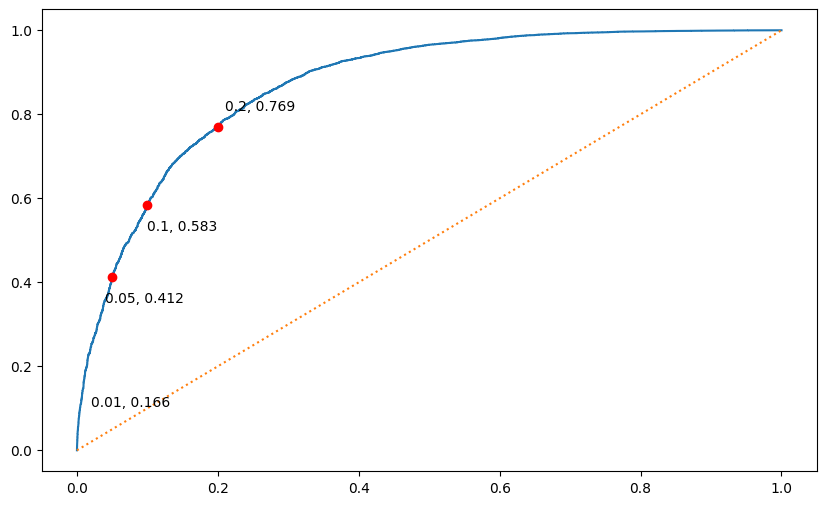

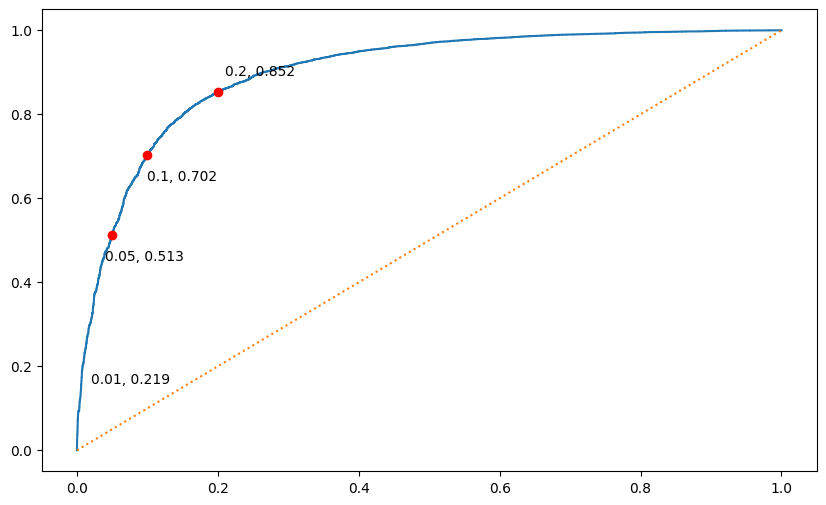

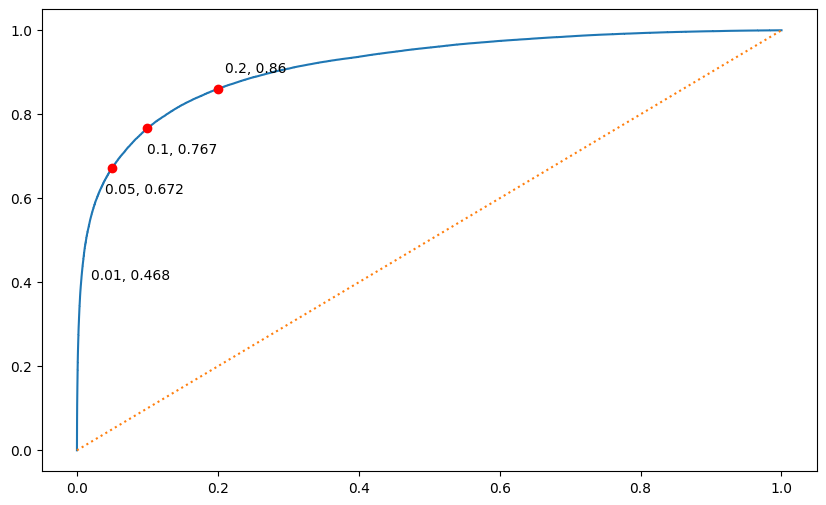

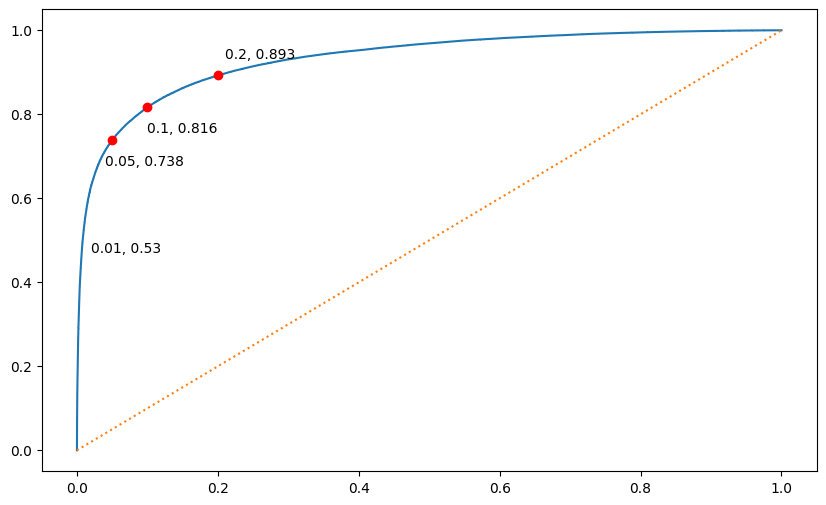

In [ ]:
plotROC(plt, input_labeled_barrel, 'barrel')
plotROC(plt, input_labeled_overlap, 'overlap')
plotROC(plt, input_labeled_endcap, 'endcap')
plotROC(plt, input_labeled, 'all')

(200000,)


/var/folders/dm/4yr9_hr53wv2zbrlrpngn_wm0000gn/T/ipykernel_92907/2292475038.py:46: RuntimeWarning: invalid value encountered in divide
  TPRrate = outHisttWgt/outHistTot
/var/folders/dm/4yr9_hr53wv2zbrlrpngn_wm0000gn/T/ipykernel_92907/2292475038.py:47: RuntimeWarning: invalid value encountered in divide
  FPRrate = outHistfWgt/outHistTot


<Figure size 640x480 with 0 Axes>

<Figure size 4500x3900 with 0 Axes>

<Figure size 1800x1500 with 0 Axes>

<Figure size 4500x3900 with 0 Axes>

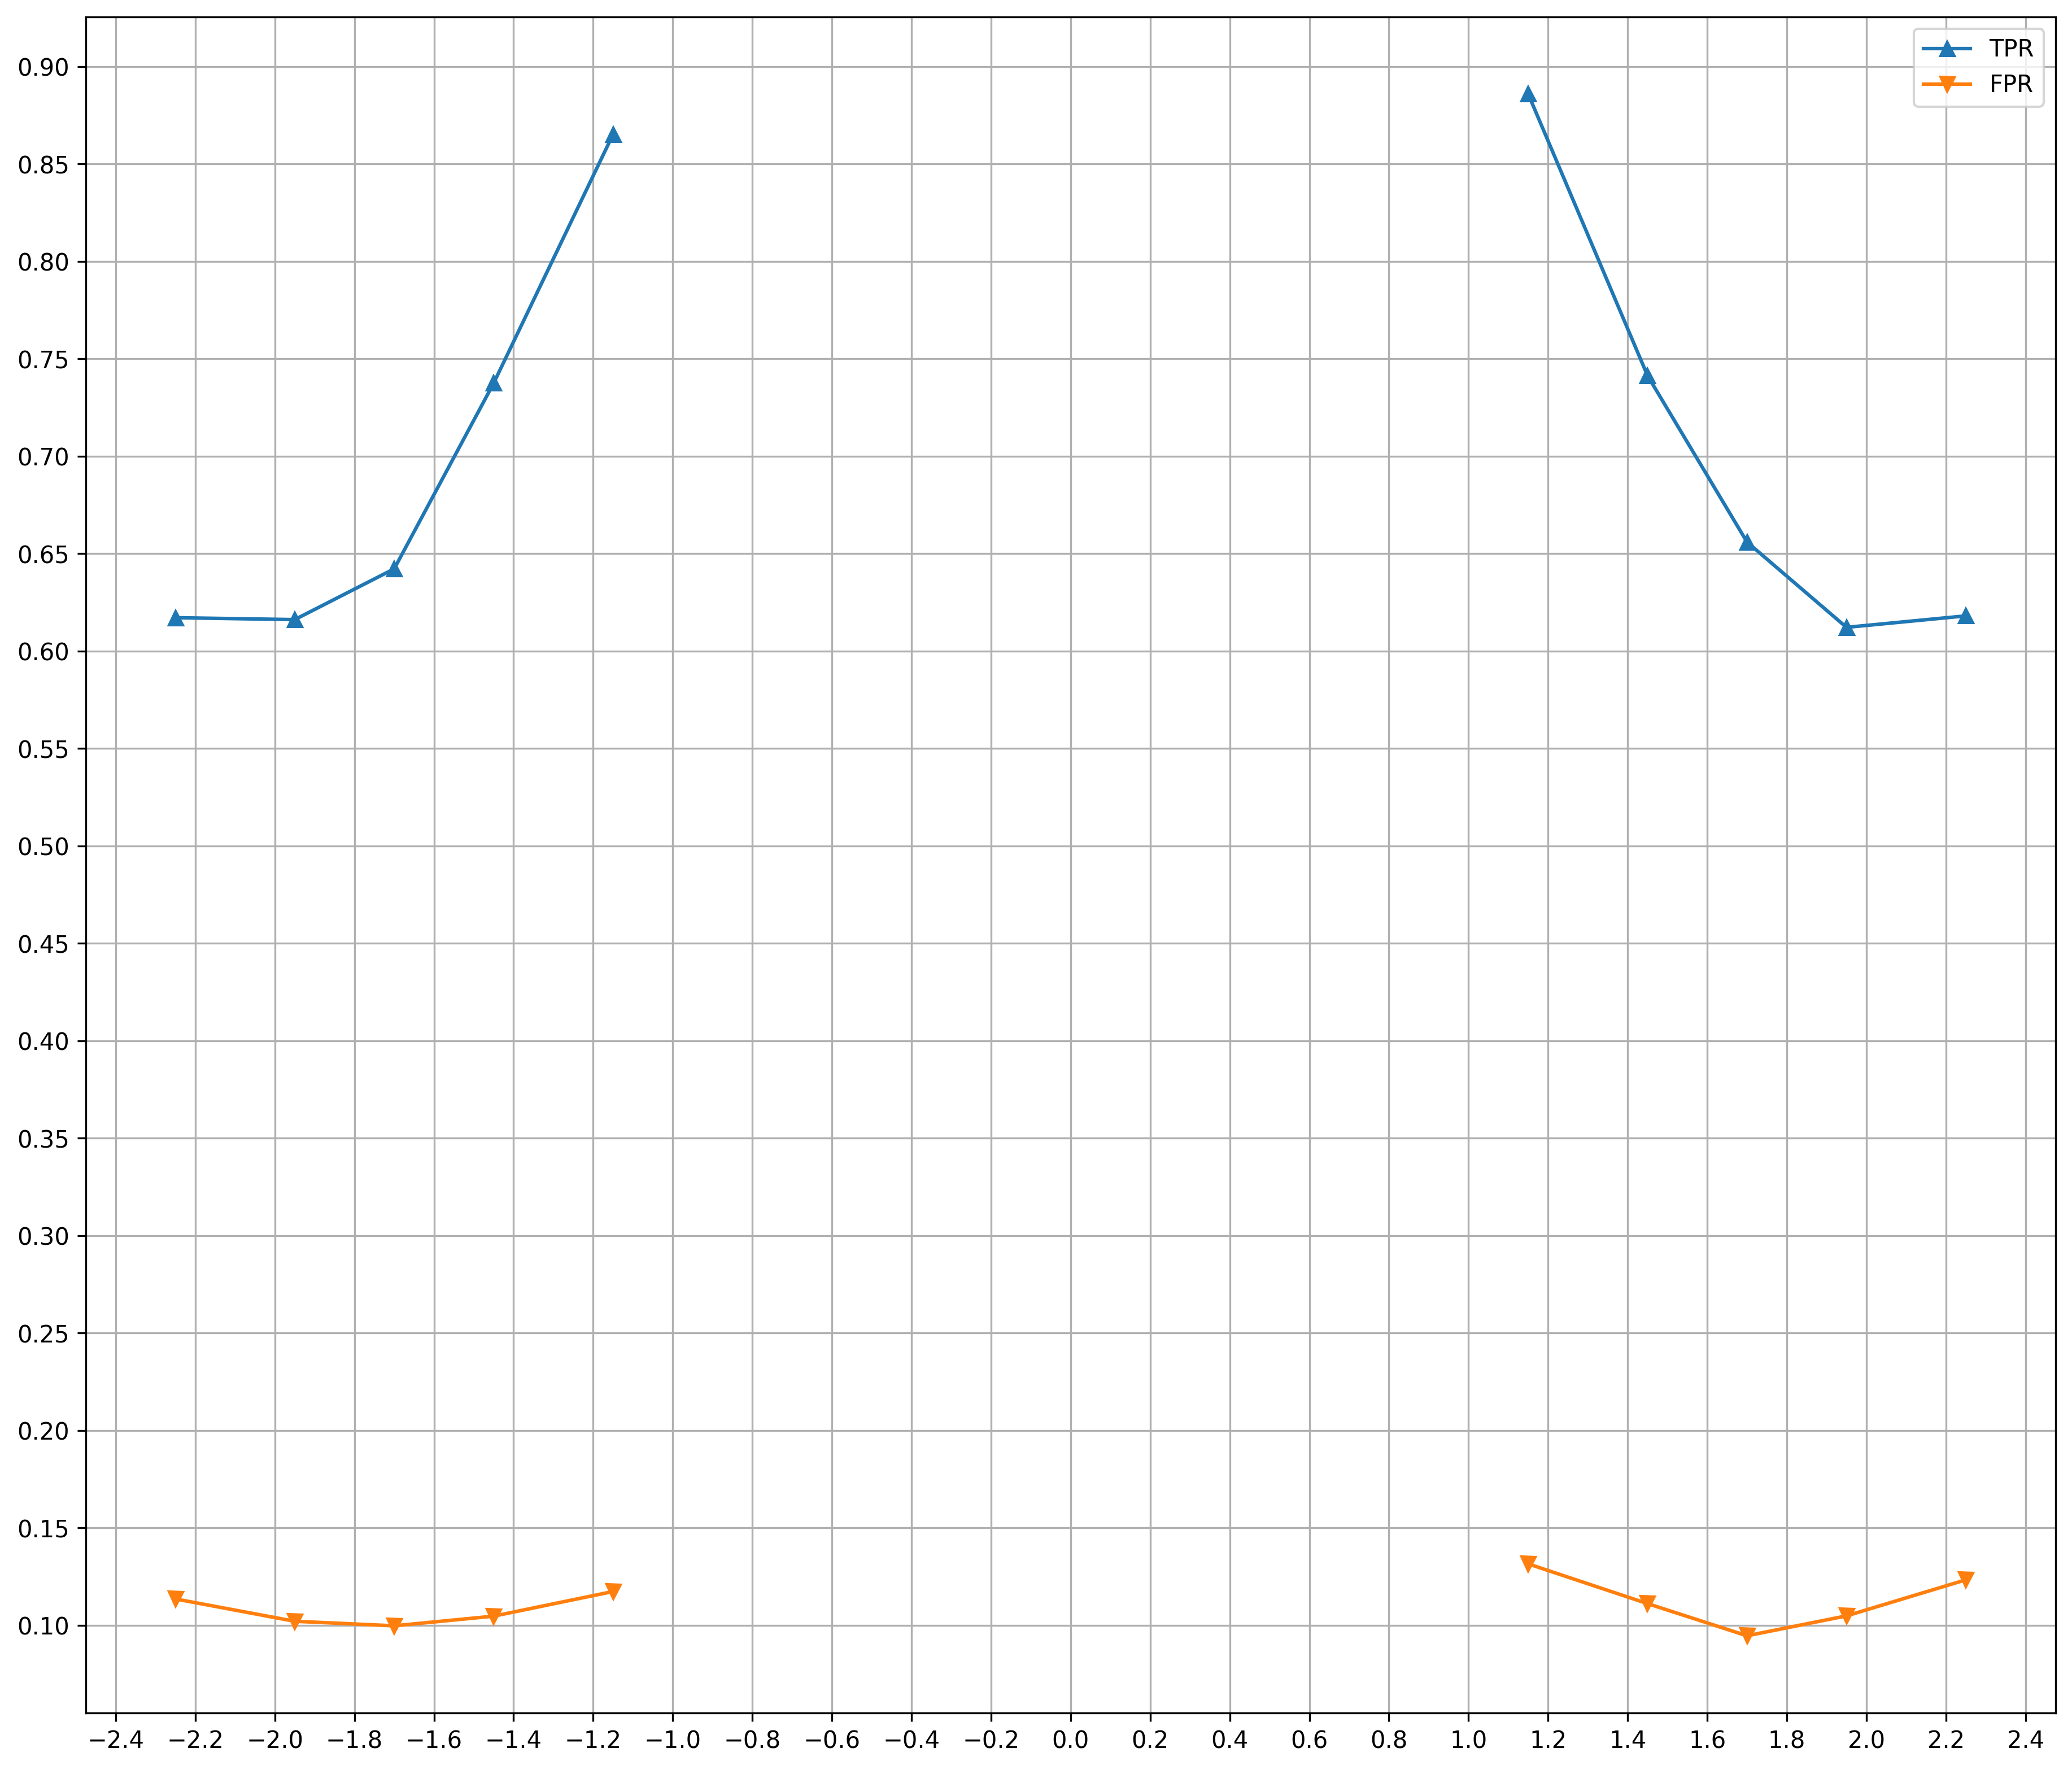

In [ ]:
plt.clf()
plt.figure(figsize=(15,13), dpi=300, facecolor='w', edgecolor='r')
numEntry = 200000
xvar = input_labeled[:numEntry,27:29]
xTruth = input_labeled[:numEntry,-1]
tprW =  xTruth *input_labeled[:numEntry,-4] 
fprW =  (1-xTruth) * (input_labeled[:numEntry,-4] )
# print(tprW)
xBins=np.array([0,0.5,1,1.5,2,2.5,3,4,5,6,7,8,9,10,12,16,20])
outHistTot,_,_ = plt.hist(xvar[:,0],xBins,weights=xTruth)
outHisttWgt,_,_ = plt.hist(xvar[:,0],xBins,weights=tprW)
outHistfWgt,_,_ = plt.hist(xvar[:,0],xBins,weights=fprW)
TPRrate = outHisttWgt/outHistTot
FPRrate = outHistfWgt/outHistTot
plt.clf()
plt.figure(figsize=(12,10), dpi=150, facecolor='w', edgecolor='r')
plt.plot(np.array([xBins[:-1]+xBins[1:]]).T/2, TPRrate, marker="^", label='TPR')
plt.plot(np.array([xBins[:-1]+xBins[1:]]).T/2, FPRrate,marker="v", label='FPR')
# plt.bar(np.array([xBins[:-1]+xBins[1:]])/2, TPRrate, align='center', width=1)
plt.grid()
plt.legend()
plt.locator_params(nbins=30)
plt.savefig("PR_pT.pdf")

xBins=np.array([-2.4,-2.1,-1.8,-1.6,-1.3,-1.0,-0.6,-0.3,0,0.3,0.6,1.0,1.3,1.6,1.8,2.1,2.4])
outHistTot,_,_ = plt.hist(xvar[xvar[:,0] >3][:,1],xBins,weights=xTruth[xvar[:,0] >3])
outHisttWgt,_,_ = plt.hist(xvar[xvar[:,0] >3][:,1],xBins,weights=tprW[xvar[:,0] >3])
outHistfWgt,_,_ = plt.hist(xvar[xvar[:,0] >3][:,1],xBins,weights=fprW[xvar[:,0] >3])
TPRrate = outHisttWgt/outHistTot
FPRrate = outHistfWgt/outHistTot
plt.clf()
plt.figure(figsize=(15,13), dpi=300, facecolor='w', edgecolor='r')
plt.plot(np.array([xBins[:-1]+xBins[1:]]).T/2, TPRrate, marker="^", label='TPR')
plt.plot(np.array([xBins[:-1]+xBins[1:]]).T/2, FPRrate,marker="v", label='FPR')
# plt.bar(np.array([xBins[:-1]+xBins[1:]])/2, TPRrate, align='center', width=1)
plt.grid()
plt.legend()
plt.locator_params(nbins=30)
plt.savefig("PR_eta_highpT.pdf")

sel = (xvar[:,0] <3) & (abs(xvar[:,1])>1.2)
print(sel.shape)
outHistTot,_,_ = plt.hist(xvar[sel][:,1],xBins,weights=xTruth[sel])
outHisttWgt,_,_ = plt.hist(xvar[sel][:,1],xBins,weights=tprW[sel])
outHistfWgt,_,_ = plt.hist(xvar[sel][:,1],xBins,weights=fprW[sel])
TPRrate = outHisttWgt/outHistTot
FPRrate = outHistfWgt/outHistTot
plt.clf()
plt.figure(figsize=(15,13), dpi=300, facecolor='w', edgecolor='r')
plt.plot(np.array([xBins[:-1]+xBins[1:]]).T/2, TPRrate, marker="^", label='TPR')
plt.plot(np.array([xBins[:-1]+xBins[1:]]).T/2, FPRrate,marker="v", label='FPR')
# plt.bar(np.array([xBins[:-1]+xBins[1:]])/2, TPRrate, align='center', width=1)
plt.grid()
plt.legend()
plt.locator_params(nbins=30)
plt.savefig("PR_eta_lowpT.pdf")


<Figure size 640x480 with 0 Axes>

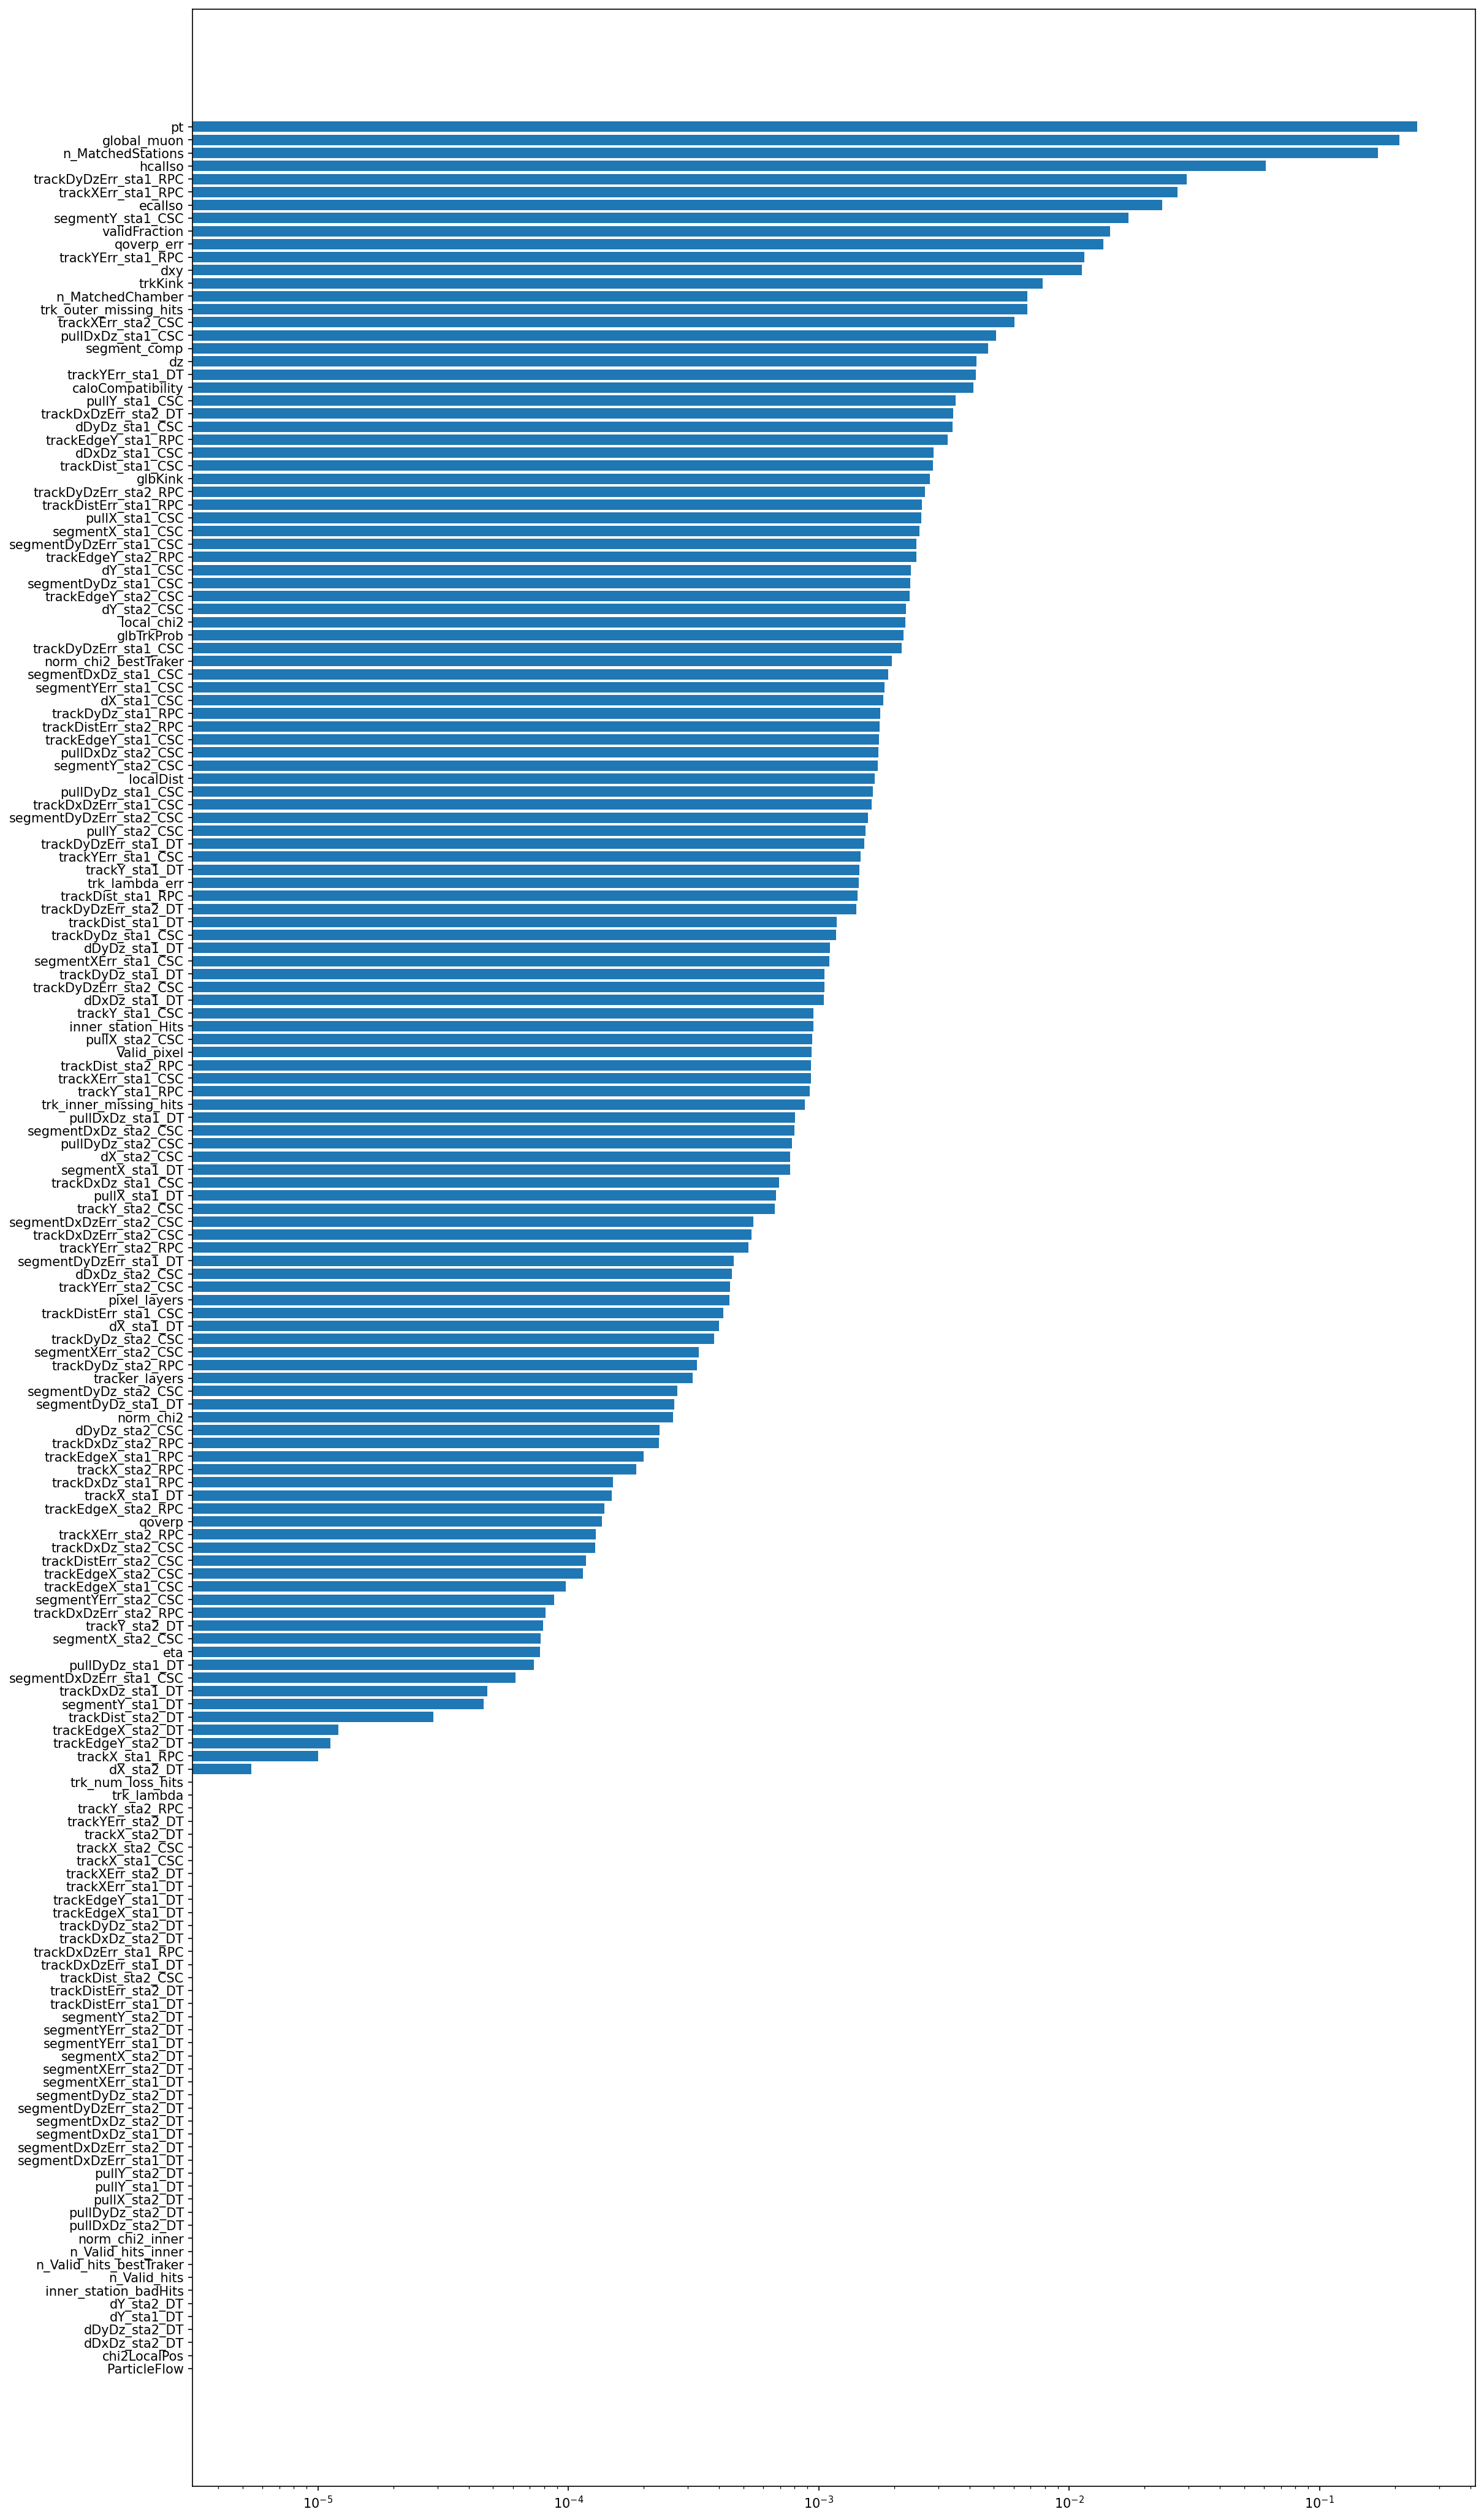

In [ ]:
plt.clf()
plt.figure(figsize=(18,35), dpi=150, facecolor='w', edgecolor='r')
sortedIV = sorted(model.feature_importances_)
sortedLab = [x for _, x in sorted(zip(model.feature_importances_,varDataTraining[10:]))]
plt.barh(sortedLab, sortedIV)
plt.xscale('log')
plt.savefig('importance.png', dpi=150)

In [15]:

dataSelhighpT = inputs_Data[:,28] >3 
dataSellowpT = inputs_Data[:,28] <3

In [14]:
inputs_Data[:10,29]

array([-2.06876206, -2.22640109,  1.80649304,  1.56526625,  1.5884552 ,
       -1.58920097, -2.18671298,  2.307868  , -1.81867564, -2.15721393])

<Figure size 640x480 with 0 Axes>

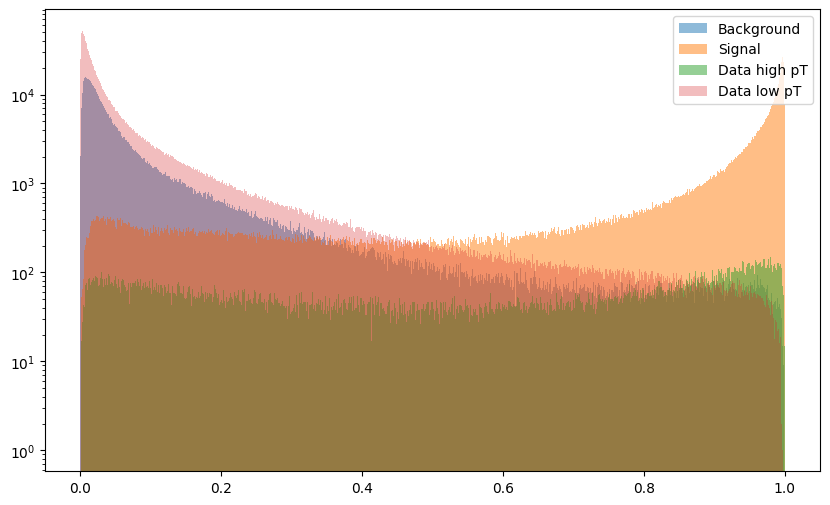

In [18]:

plt.clf()
# Create histogram to plot pred_prob[0] and pred_prob[1]
plt.figure(figsize=(10, 6), facecolor='w', edgecolor='r')
plt.hist(pred_labeled[pred_labeled[:,-1]==0, 1], bins=1000, label='Background', alpha=0.5)
plt.hist(pred_labeled[pred_labeled[:,-1]==1, 1], bins=1000, label='Signal', alpha=0.5)
plt.hist(pred_prob_data[dataSelhighpT][:,1], bins=1000, label='Data high pT', alpha=0.5)
plt.hist(pred_prob_data[dataSellowpT][:,1], bins=1000, label='Data low pT', alpha=0.3)
plt.legend(loc='upper right')
plt.yscale('log')
plt.savefig('pred_prob.pdf')



In [ ]:

print("stack shape (aux, nom")
print(inputs_test.shape)
print("input shape:")
print(inputs_test.shape)
inputsAux_train = np.hstack((inputsAux_train, inputs_train, labels_train))
inputsAux_test = np.hstack((inputsAux_test, inputs_test, labels_test))
inputsAll = np.vstack((inputsAux_train, inputsAux_test))
# Add variables to save
variables_dict.update({'prob0': 'float64', 'prob1': 'float64', 'label': 'int32'})
# Save the data to root file
if saveTree:
    with uproot.recreate('test_xgb_test.root') as f:
        print(variables_dict)
        f.mktree("newT", variables_dict)
        print(vardim)
        entry = { varDataTraining[i] : inputsAll[:,i] for i in range(vardim)}
        entry['prob0'] = pred_prob[:,0]
        entry['prob1'] = pred_prob[:,1]
        entry['label'] = inputsAll[:,-1]
        f['newT'].extend(entry)
    # for i in range(vardim):
    #     print(i)
    #     f["newT"].extend({variables[i]: inputs_test[:,i]})

# Compute the number of correct predictions
print("predictions shape")
print( predictions.shape)
print(labels_test.shape)
total_correct += (predictions.reshape(-1,1) == labels_test).sum()

# Compute the total number of samples
total_samples += labels_test.size

# # Compute the accuracy of the model on the test set
accuracy = total_correct / total_samples
print("Accuracy: {:.2f}%".format(accuracy * 100))